In [1]:
import pandas as pd
import numpy as np
# To display all the columns
pd.options.display.max_columns = None
import os
import json
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn import linear_model as lm

In [2]:
# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import PolynomialFeatures
import tensorflow as tf
huber_loss = tf.keras.losses.Huber()

# Define score
r2 = make_scorer(r2_score, greater_is_better=True)

per_order = ['normal', 'DMSO']

def plot_y_vs_y_hat(df, y_hat):
    
    # Create df with perturbations
    per_df = metadata[['mapobject_id_cell', 'perturbation']]
    temp_df = df.merge(
        per_df, 
        left_on='mapobject_id_cell',
        right_on='mapobject_id_cell',
        how='left',
    )

    sns.scatterplot(data=temp_df,
                    x='y',
                    y=y_hat,
                    hue='perturbation',
                    hue_order=per_order,
                    #s=15,
                    alpha=0.5)
    plt.axis('equal')

    min_val = df[['y', y_hat]].min().values.min()
    max_val = df[['y', y_hat]].max().values.min()

    x_line = [min_val, max_val]
    y_line = x_line
    plt.plot(x_line, y_line, linestyle='dashed', color='red')
    plt.title(y_hat)

def plot_residuals(df, y_hat):
    
    # Create df with perturbations
    per_df = metadata[['mapobject_id_cell', 'perturbation']]
    temp_df = df.merge(
        per_df, 
        left_on='mapobject_id_cell',
        right_on='mapobject_id_cell',
        how='left',
    )
    
    temp_df['diff'] = temp_df['y'] - temp_df[y_hat]
    std = temp_df['diff'].std()
    temp_df['std_residuals'] = temp_df['diff'] / std
    
    sns.scatterplot(
        data=temp_df,
        x = 'y',
        y = 'std_residuals',
        hue = 'perturbation',
        hue_order=per_order,
    )
    plt.hlines(y=2, xmin=np.min(temp_df['y']), xmax=np.max(temp_df['y']), color='red', ls='dashed')
    plt.hlines(y=-2, xmin=np.min(temp_df['y']), xmax=np.max(temp_df['y']), color='red', ls='dashed')
    plt.title(y_hat)

def plot_error_dist(df, y_models):
    temp_df = df.copy()
    
    # Add perturbations to df
    per_df = metadata[['mapobject_id_cell', 'perturbation']]
    temp_df = temp_df.merge(
        per_df, 
        left_on='mapobject_id_cell',
        right_on='mapobject_id_cell',
        how='left',
    )
    
    diff_names = ['set', 'perturbation']
    for y_model in y_models:
        # Column name for difference between y and y_model
        col_name = 'y - '+y_model
        diff_names.append(col_name)
        temp_df[col_name] = temp_df['y'] - temp_df[y_model]
        
    temp_df = temp_df[diff_names].set_index(['set', 'perturbation'])
    temp_df = temp_df.stack().reset_index()
    #temp_df = temp_df.drop(['level_0'], axis=1)
    temp_df.columns = ['set', 'perturbation'] + ['diff_name', 'value']
    
    plt.figure(figsize=(20,7))
    sns.kdeplot(x='value',
                #common_norm=True,
                data=temp_df,
                hue='diff_name',
                #hue_order=order,
                #color=colors,
                shade=True, 
                bw_method=0.2)

    plt.vlines(x=0, ymin=0, ymax=0.003, color='red', ls='dashed')
    plt.xlabel('y - y_hat')
    plt.title('Error KDE per model')
    
    plt.figure(figsize=(20,7))
    sns.boxplot(y='value',
                x='diff_name',
                hue='perturbation',
                hue_order=per_order,
                data=temp_df)
    plt.xlabel('Diff Name')
    plt.ylabel('y - y_hat')
    plt.title('Error Distribution per set')
    
# Add metrics to metrics df
def calculate_and_save_metric_vals(df, y_model, k):
    # Create df to store metrics to compare models
    metric_columns = ['model', 'set', 'R2', 'BIC', 'MSE', 'MAE', 'Huber']
    temp_df = pd.DataFrame(columns=metric_columns)
    
    sets = ['train', 'val', 'test']
    for ss in sets:
        mask = (metadata['set'] == ss)
        y = df['y'][mask].values
        #print(y.shape)
        #print(df['y_Poly_Lasso'].shape)
        y_hat = df[y_model][mask].values
        
        r2 = r2_score(y, y_hat)
        bic = get_BIC(y=y, y_hat=y_hat, k=k)
        mse = mean_squared_error(y, y_hat)
        mae = mean_absolute_error(y, y_hat)
        huber = huber_loss(y, y_hat).numpy()
        temp_df = temp_df.append({'model':y_model[2:], 'set':ss, 'R2':r2, 'BIC':bic, 'MSE':mse, 'MAE':mae, 'Huber':huber}, ignore_index=True)
    
    return temp_df.round(4)

def get_BIC(y, y_hat, k):
    SS_residual = np.sum((y-y_hat)**2)
    n = y.shape[0]
    return n * np.log(SS_residual / n) + np.log(n) * k
    
def get_polynomial_dataset(X_array=None, X_array_names=None, degree=1, interaction_only=False):
    # Init the pipeline to create the dataset 
    poly_trans = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=False)
    # Create the dataset
    X_temp = poly_trans.fit_transform(X_array)
    # Get the interactions names
    X_temp_names = poly_trans.get_feature_names(X_array_names)
    
    return X_temp, X_temp_names

def plot_coef(df, x_name='coef', y_name='var_name'):
    temp_df = df.sort_values(by=[x_name], ascending=False)
    plt.figure(figsize=(15,20))
    sns.barplot(
        data=temp_df,
        x=x_name,
        y=y_name,
        orient="h",
        palette="viridis"
        )

In [3]:
# Preprocessed data path
pp_path = '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_avg_projection_splited'
os.listdir(pp_path)

['params.json', 'channels.csv', 'metadata.csv']

In [4]:
with open(os.path.join(pp_path, 'metadata.csv')) as file:
    metadata = pd.read_csv(file)
    # remove duplicated items (there are not duplicated items among different sets (train, val and test))
    metadata = metadata.groupby(['mapobject_id'], sort=False, as_index=False).first()
    
with open(os.path.join(pp_path, 'channels.csv')) as file:
    channels = pd.read_csv(file)

with open(os.path.join(pp_path, 'params.json')) as file:
    pp = json.load(file)
pp.keys()

dict_keys(['_comment', 'raw_data_dir', 'dir_type', 'perturbations_and_wells', 'external_libs_path', 'output_data_dir', 'seed', 'input_channels', 'output_channels', 'aggregate_output', 'train_frac', 'val_frac', 'img_size', 'subtract_background', 'background_value', 'normalise', 'percentile', 'add_cell_cycle_to_metadata', 'cell_cycle_file', 'add_well_info_to_metadata', 'well_info_file', 'filter_criteria', 'filter_values', 'convert_into_image', 'remove_original_data', 'project_into_scalar', 'method', 'log_file', 'log_level', 'data_dirs', 'normalise_rescale_values', 'normalise_rescale_values_scalars', 'output_files'])

In [5]:
# Add normalization values to channel df
channels['normalization_val'] = pp['normalise_rescale_values_scalars']
channels.drop(['Unnamed: 0'], axis=1, inplace=True)
channels

,channel_id,name,normalization_val
0,0,00_DAPI,56.132246
1,1,07_H2B,274.264162
2,2,01_CDK9_pT186,21.499582
3,3,03_CDK9,46.196136
4,4,05_GTF2B,126.727922
5,5,07_SETD1A,42.536269
6,6,08_H3K4me3,64.211107
7,7,09_SRRM2,73.813698
8,8,10_H3K27ac,292.815155
9,9,11_KPNA2_MAX,103.422563


In [6]:
mask_perturbation = (metadata['perturbation'] == 'normal')
mask_perturbation |= (metadata['perturbation'] == 'DMSO')
metadata = metadata[mask_perturbation].reset_index().drop(['index'], axis=1)
metadata

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,mapobject_id_cell,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,00_DAPI_avg,07_H2B_avg,01_CDK9_pT186_avg,03_CDK9_avg,05_GTF2B_avg,07_SETD1A_avg,08_H3K4me3_avg,09_SRRM2_avg,10_H3K27ac_avg,11_KPNA2_MAX_avg,12_RB1_pS807_S811_avg,13_PABPN1_avg,14_PCNA_avg,15_SON_avg,16_H3_avg,17_HDAC3_avg,19_KPNA1_MAX_avg,20_SP100_avg,21_NCL_avg,01_PABPC1_avg,02_CDK7_avg,03_RPS6_avg,05_Sm_avg,07_POLR2A_avg,09_CCNT1_avg,10_POL2RA_pS2_avg,11_PML_avg,12_YAP1_avg,13_POL2RA_pS5_avg,15_U2SNRNPB_avg,18_NONO_avg,20_ALYREF_avg,21_COIL_avg,00_BG488_avg,00_BG568_avg,00_EU_avg,09_SRRM2_ILASTIK_avg,15_SON_ILASTIK_avg,set
0,263055,plate01,J16,0,0,0,0,4,0,263042,plate01,J16,0,0,0,0,4,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,0.705659,1.028980,0.684189,0.746412,0.963699,0.691370,0.748778,0.765551,0.245359,0.908886,0.780641,0.716928,0.829434,0.768822,0.882689,1.156642,1.059710,0.513018,0.801879,0.834295,0.722357,1.115627,0.941399,0.743345,0.614370,0.900354,0.326190,0.540706,0.891108,0.671243,0.906927,0.835702,0.937988,0.964588,0.946783,0.915032,0.771456,0.697269,train
1,263056,plate01,J16,0,0,0,0,5,0,263043,plate01,J16,0,0,0,0,5,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,0.621474,0.910596,0.678523,0.730147,0.826866,0.598236,0.554406,0.744817,0.164135,0.873646,0.701342,0.662154,0.924794,0.762980,0.840988,1.070790,0.989439,0.401625,0.732974,0.671316,0.726729,0.950857,0.810480,0.693435,0.649292,0.865672,0.433144,0.699466,0.849924,0.632156,0.834961,0.906596,0.871321,0.883920,0.935159,0.978496,0.877303,0.829129,train
2,263057,plate01,J16,0,0,0,0,6,0,263044,plate01,J16,0,0,0,0,6,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,DMSO,720.0,0.559914,0.673521,0.367085,0.416994,0.645986,0.562562,0.459997,0.536572,0.133353,0.747884,0.092656,0.680816,0.416561,0.450028,0.597563,0.924112,0.989534,0.139680,0.387210,0.756921,0.290736,0.915663,0.535581,0.474428,0.482097,0.738551,0.392874,0.724019,0.614959,0.582054,0.706530,0.590277,0.675308,0.910371,0.964073,0.789988,0.571108,0.550479,train
3,263058,plate01,J16,0,0,0,0,7,0,263045,plate01,J16,0,0,0,0,7,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,0.772267,0.880395,0.842348,0.965477,0.970396,0.954589,0.759372,0.786802,0.263008,1.172697,0.751818,0.725942,0.824342,0.774902,0.871545,1.083925,0.948059,0.697179,0.841382,0.664082,0.830332,0.874028,0.905953,0.943999,0.814373,0.841377,0.485284,0.677689,0.853363,0.702255,0.908915,0.837628,0.888862,0.887522,0.947727,0.784347,0.804344,0.726761,train
4,263060,plate01,J16,0,0,0,0,9,0,263047,plate01,J16,0,0,0,0,9,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,DMSO,720.0,0.501752,0.544152,1.288875,1.577494,1.167879,1.208178,0.887331,1.574985,0.194347,0.647281,0.699402,0.854071,0.520319,1.073794,0.366597,1.098936,0.955131,1.623222,0.766097,0.825827,0.963407,1.126784,1.200570,1.321706,1.195229,0.813766,0.843695,1.097583,0.611882,1.071663,0.626599,0.408824,0.841230,0.998162,1.053085,1.172326,1.504990,1.011448,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,196980,plate01,J12,5,3,0,0,16,0,196946,plate01,J12,5,3,0,0,16,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,0.466116,0.427223,0.524259,0.559983,0.778531,0.549776,0.643514,0.551811,0.193130,0.478116,0.712937,0.743597,0.522384,0.581592,0.384521,0.480271,0.515179,0.437035,0.545412,0.428227,0.565138,0.481548,0.577957,0.520295,0.529232,0.743118,0.569474,0.409859,0.606166,0.481509,0.666436,0.509698,0.621739,0.579675,0.892434,0.762380,0.589774,0.685176,test
3699,266544,plate01,J12,5,4,0,0,23,0,266495,plate01,J12,5,4,0,0,23,0,0.0,NaN,0.

In [7]:
# Create masks for train, val, cv (cv = train + val) and test
mask_train = (metadata['set'] == 'train')
print(np.sum(mask_train))

mask_val = (metadata['set'] == 'val')
print(np.sum(mask_val))

mask_test = (metadata['set'] == 'test')
print(np.sum(mask_test))

mask_cv = mask_train | mask_val


2959
368
376


In [8]:
x_columns = [c+'_'+pp['method'] for c in pp['input_channels']]
# Discriminate channels: 
drop_cols = ['00_BG488_avg', '00_BG568_avg', '09_SRRM2_ILASTIK_avg', '15_SON_ILASTIK_avg']
x_columns = [c for c in x_columns if not c in drop_cols]

# Create dfs
X = metadata[x_columns].copy()
# Remove projection method from name
channel_columns = [c[:-(len(pp['method'])+1)] for c in X.columns]
X.columns = channel_columns
X

,00_DAPI,07_H2B,01_CDK9_pT186,03_CDK9,05_GTF2B,07_SETD1A,08_H3K4me3,09_SRRM2,10_H3K27ac,11_KPNA2_MAX,12_RB1_pS807_S811,13_PABPN1,14_PCNA,15_SON,16_H3,17_HDAC3,19_KPNA1_MAX,20_SP100,21_NCL,01_PABPC1,02_CDK7,03_RPS6,05_Sm,07_POLR2A,09_CCNT1,10_POL2RA_pS2,11_PML,12_YAP1,13_POL2RA_pS5,15_U2SNRNPB,18_NONO,20_ALYREF,21_COIL
0,0.705659,1.028980,0.684189,0.746412,0.963699,0.691370,0.748778,0.765551,0.245359,0.908886,0.780641,0.716928,0.829434,0.768822,0.882689,1.156642,1.059710,0.513018,0.801879,0.834295,0.722357,1.115627,0.941399,0.743345,0.614370,0.900354,0.326190,0.540706,0.891108,0.671243,0.906927,0.835702,0.937988
1,0.621474,0.910596,0.678523,0.730147,0.826866,0.598236,0.554406,0.744817,0.164135,0.873646,0.701342,0.662154,0.924794,0.762980,0.840988,1.070790,0.989439,0.401625,0.732974,0.671316,0.726729,0.950857,0.810480,0.693435,0.649292,0.865672,0.433144,0.699466,0.849924,0.632156,0.834961,0.906596,0.871321
2,0.559914,0.673521,0.367085,0.416994,0.645986,0.562562,0.459997,0.536572,0.133353,0.747884,0.092656,0.680816,0.416561,0.450028,0.597563,0.924112,0.989534,0.139680,0.387210,0.756921,0.290736,0.915663,0.535581,0.474428,0.482097,0.738551,0.392874,0.724019,0.614959,0.582054,0.706530,0.590277,0.675308
3,0.772267,0.880395,0.842348,0.965477,0.970396,0.954589,0.759372,0.786802,0.263008,1.172697,0.751818,0.725942,0.824342,0.774902,0.871545,1.083925,0.948059,0.697179,0.841382,0.664082,0.830332,0.874028,0.905953,0.943999,0.814373,0.841377,0.485284,0.677689,0.853363,0.702255,0.908915,0.837628,0.888862
4,0.501752,0.544152,1.288875,1.577494,1.167879,1.208178,0.887331,1.574985,0.194347,0.647281,0.699402,0.854071,0.520319,1.073794,0.366597,1.098936,0.955131,1.623222,0.766097,0.825827,0.963407,1.126784,1.200570,1.321706,1.195229,0.813766,0.843695,1.097583,0.611882,1.071663,0.626599,0.408824,0.841230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,0.466116,0.427223,0.524259,0.559983,0.778531,0.549776,0.643514,0.551811,0.193130,0.478116,0.712937,0.743597,0.522384,0.581592,0.384521,0.480271,0.515179,0.437035,0.545412,0.428227,0.565138,0.481548,0.577957,0.520295,0.529232,0.743118,0.569474,0.409859,0.606166,0.481509,0.666436,0.509698,0.621739
3699,0.637199,0.383999,0.418047,0.527632,0.613568,0.470998,0.641225,0.419378,0.319716,0.322750,0.549373,0.583993,0.507319,0.553977,0.414093,0.429652,0.442965,0.345834,0.479689,0.316905,0.423932,0.360906,0.469056,0.488063,0.413873,0.745399,0.350399,0.184317,0.526459,0.397377,0.511406,0.452926,0.454194
3700,0.579194,0.412988,0.381970,0.441706,0.496858,0.335659,0.515844,0.383102,0.285956,0.334541,0.478602,0.642649,0.590243,0.519747,0.445927,0.466204,0.501111,0.441162,0.421151,0.326183,0.351802,0.368628,0.440929,0.392850,0.362778,0.626234,0.495860,0.277251,0.535496,0.378879,0.555842,0.478219,0.447294
3701,0.481913,0.481001,0.408701,0.438119,0.750543,0.462461,0.598127,0.562935,0.176255,0.414752,0.821986,0.644833,0.302289,0.691286,0.509955,0.497737,0.480673,0.389919,0.529000,0.372712,0.573087,0.431294,0.516686,0.474053,0.334629,0.718572,0.518643,0.276903,0.637072,0.440410,0.698329,0.557219,0.568876


In [9]:
y_columns = pp['output_channels'][0]+'_'+pp['method'] 
Y = pd.DataFrame(metadata[y_columns])
Y.columns = [pp['output_channels'][0]]
# Revert normalization of target var
y_norm_val = channels.set_index('name').loc[pp['output_channels']].normalization_val.values[0]
Y = Y * y_norm_val
Y

,00_EU
0,431.543626
1,461.474236
2,372.570739
3,369.910382
4,552.887343
...,...
3698,359.550328
3699,375.614026
3700,316.716326
3701,400.227596


<AxesSubplot:ylabel='00_EU'>

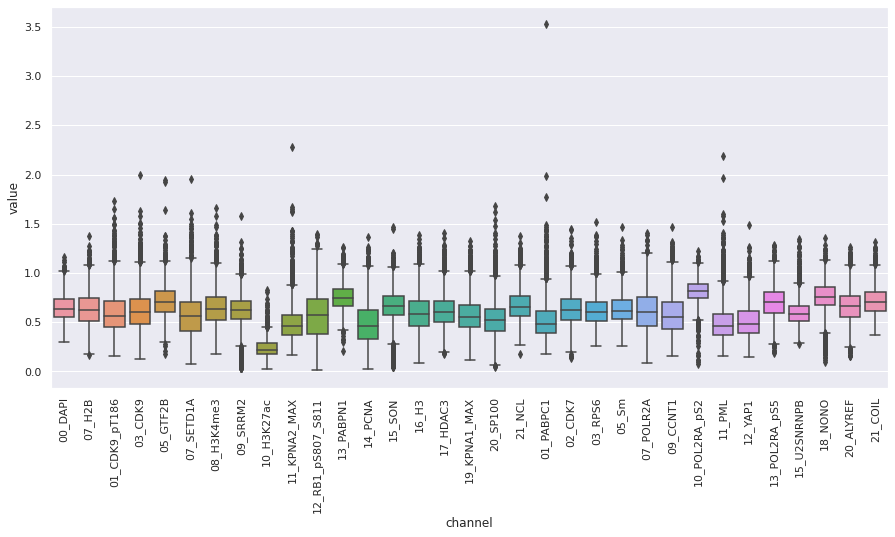

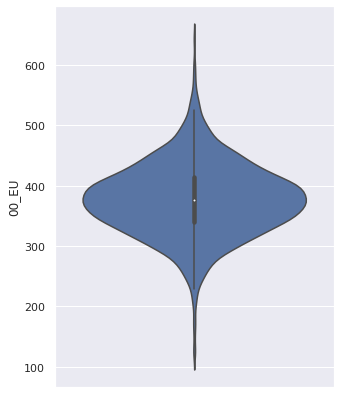

In [10]:
# Plot data distribution
temp_df = X.copy()
temp_df = temp_df.stack().reset_index()
temp_df = temp_df.drop(['level_0'], axis=1)
temp_df.columns = ['channel', 'value']
temp_df

plt.figure(figsize=(15,7))
sns.boxplot(data=temp_df,
            x='channel',
            y='value')
_,_ = plt.xticks(rotation=90)

plt.figure(figsize=(5,7))
sns.violinplot(data=Y,
            y='00_EU')
#sns.swarmplot(data=Y,
#             y='00_EU')

Create a DataFrame that will contain the predictions of all the models:

In [11]:
predictions_df = metadata[['mapobject_id_cell', 'set']+[y_columns]].copy()
predictions_df.columns = ['mapobject_id_cell', 'set', 'y']
predictions_df['y'] = (predictions_df['y'].values * y_norm_val)
predictions_df

,mapobject_id_cell,set,y
0,263042,train,431.543626
1,263043,train,461.474236
2,263044,train,372.570739
3,263045,train,369.910382
4,263047,train,552.887343
...,...,...,...
3698,196946,test,359.550328
3699,266495,test,375.614026
3700,266507,test,316.716326
3701,266512,test,400.227596


## OLS

In [12]:
# Create and fit lm
ols_model = lm.LinearRegression(n_jobs=6).fit(X[mask_train].values, Y[mask_train].values)

In [13]:
# Create df that will contain all the coefficients
values = np.append(ols_model.intercept_, ols_model.coef_)
coef_df = pd.DataFrame(np.round(values,4))
coef_df['Variable'] = ['intercept'] + list(X.columns)
coef_df.columns = ['ols', 'Variable']

In [14]:
# Add predictions to df
predictions_df['y_ols'] = ols_model.predict(X.values)

In [15]:
# Get number of predictors
k = sum(coef_df['ols'] != 0)
temp_metrics_df = calculate_and_save_metric_vals(df=predictions_df, y_model='y_ols', k=k)
metric_vals_df = temp_metrics_df.copy()

In [16]:
#plot_coef(df=coef_df, x_name='ols', y_name='Variable')

## Linear regression with Regularization

For regularization method we use cross validation to approximate the best hyperparameters. 

In [17]:
from sklearn.model_selection import GridSearchCV

### ElasticNet

In [18]:
enet = lm.ElasticNet()
params_enet = {'alpha':np.arange(0.001, 0.1, 0.001), 
               'l1_ratio':np.arange(0.05, 1.05, 0.05), 
               'normalize':[False]}
enet_grid = GridSearchCV(enet, params_enet, scoring = r2, cv=5)

In [19]:
# Fit ElasticNet 
enet_grid.fit(X[mask_cv].values, Y[mask_cv].values)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.04...
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099]),
                         'l1_ratio': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'normalize': [False]},
             scoring=make_scorer(r2_score

In [20]:
# Print best hyperparameters
enet_grid.best_estimator_

ElasticNet(alpha=0.048, l1_ratio=1.0)

In [21]:
# Add coefficients to coef df
values = np.round(np.append(enet_grid.best_estimator_.intercept_, enet_grid.best_estimator_.coef_), 4)
coef_df['Elastic'] = values

In [22]:
# Save fitted values
predictions_df['y_elastic'] = enet_grid.best_estimator_.predict(X.values)

In [23]:
# Get number of predictors
k = sum(coef_df['Elastic'] != 0)
# Get and save metrics values for this model
temp_metrics_df = calculate_and_save_metric_vals(df=predictions_df, y_model='y_elastic', k=k)
metric_vals_df = metric_vals_df.append(temp_metrics_df, ignore_index=True)

In [24]:
#plot_coef(df=coef_df, x_name='Elastic', y_name='Variable')

### Ridge

In [25]:
ridge = lm.Ridge()
params_rige = {'alpha':np.arange(0.009, 0.02, 0.001), 'normalize':[True]}
ridge_grid = GridSearchCV(ridge, params_rige, scoring=r2, cv=5)

In [26]:
# Fit Ridge 
ridge_grid.fit(X[mask_cv].values, Y[mask_cv].values)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019]),
                         'normalize': [True]},
             scoring=make_scorer(r2_score))

In [27]:
ridge_grid.best_estimator_

Ridge(alpha=0.01899999999999999, normalize=True)

In [28]:
# Add coefficients to coef df
values = np.round(np.append(ridge_grid.best_estimator_.intercept_, ridge_grid.best_estimator_.coef_), 4)
coef_df['Ridge'] = values

In [29]:
# Save fitted values
predictions_df['y_ridge'] = ridge_grid.best_estimator_.predict(X.values)

In [30]:
# Get number of predictors
k = sum(coef_df['Ridge'] != 0)
# Get and save metrics values for this model
temp_metrics_df = calculate_and_save_metric_vals(df=predictions_df, y_model='y_ridge', k=k)
metric_vals_df = metric_vals_df.append(temp_metrics_df, ignore_index=True)

In [31]:
#plot_coef(df=coef_df, x_name='Ridge', y_name='Variable')

### Lasso

In [32]:
lasso = lm.Lasso()
#params_lasso = {'alpha':np.arange(1e-6, 1e-5, 1e-6), 'normalize':[False]}
params_lasso = {'alpha':np.arange(0.001, 0.1, 0.001), 'normalize':[False]}
lasso_grid = GridSearchCV(lasso, params_lasso, scoring=r2, cv=5, n_jobs=7, verbose=2)

In [33]:
# Fit Lasso 
lasso_grid.fit(X[mask_cv].values, Y[mask_cv].values)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    1.3s
[Parallel(n_jobs=7)]: Done 495 out of 495 | elapsed:    2.6s finished


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=7,
             param_grid={'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047,...51, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099]),
                         'normalize': [False]},
             scoring=make_scorer(r2_score), verbose=2)

In [34]:
lasso_grid.best_estimator_

Lasso(alpha=0.048)

In [35]:
# Add coefficients to coef df
values = np.round(np.append(lasso_grid.best_estimator_.intercept_, lasso_grid.best_estimator_.coef_), 4)
coef_df['Lasso'] = values

In [36]:
# Save fitted values
predictions_df['y_Lasso'] = lasso_grid.best_estimator_.predict(X.values)

In [37]:
# Get number of predictors
k = sum(coef_df['Lasso'] != 0)
# Get and save metrics values for this model
temp_metrics_df = calculate_and_save_metric_vals(df=predictions_df, y_model='y_Lasso', k=k)
metric_vals_df = metric_vals_df.append(temp_metrics_df, ignore_index=True)

In [38]:
#plot_coef(df=coef_df, x_name='Lasso', y_name='Variable')

### Coefficient Analysis

<AxesSubplot:xlabel='value', ylabel='variable'>

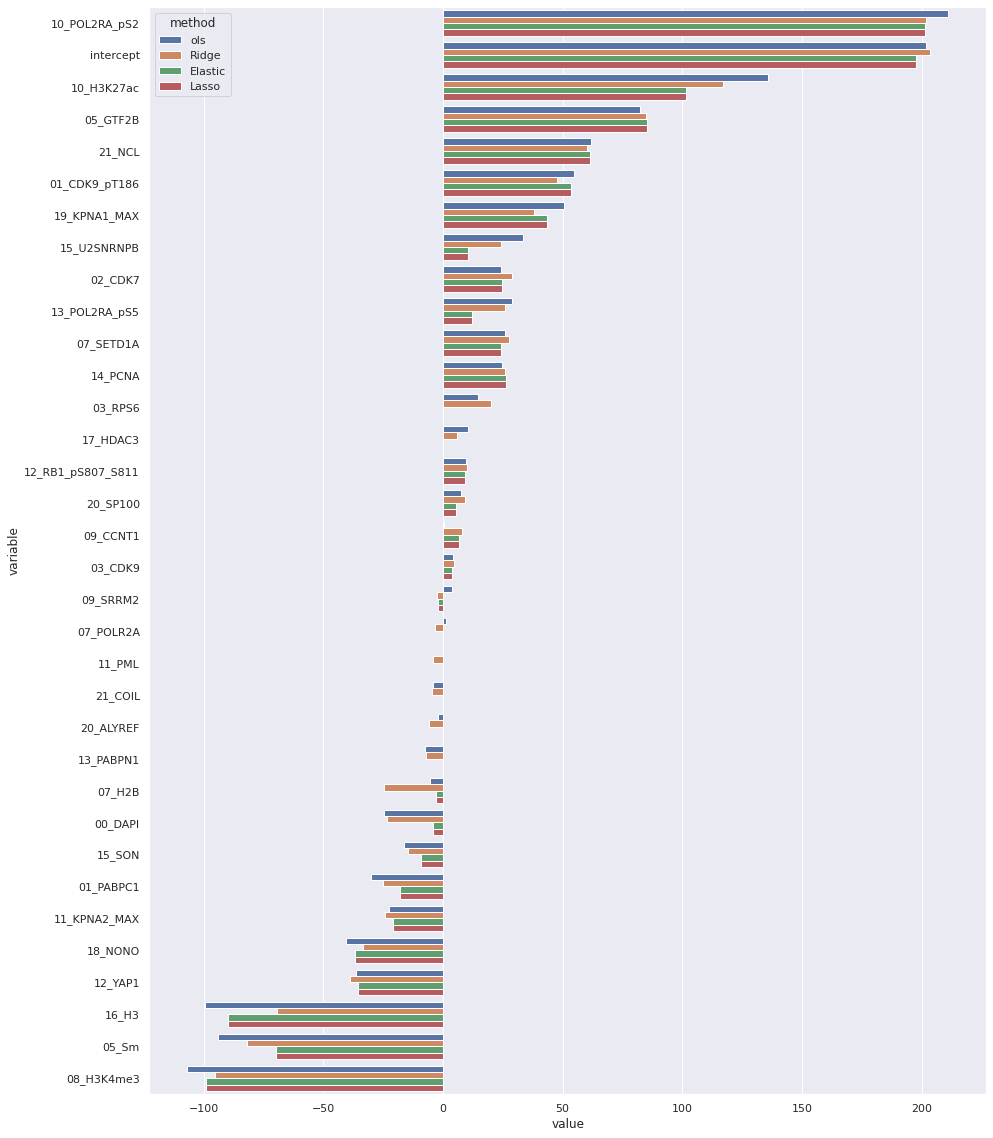

In [39]:
#order = ['ols', 'ols_no_indi', 'Ridge', 'Elastic', 'Lasso']
order = ['ols', 'Ridge', 'Elastic', 'Lasso']

temp_df = coef_df[['Variable']+order].copy()
temp_df = temp_df.set_index('Variable').stack().reset_index()
temp_df.columns = ['variable', 'method', 'value']
temp_df = temp_df.sort_values(by=['value'], ascending=False)


plt.figure(figsize=(15,20))
sns.barplot(
    data=temp_df,
    #data=temp_df[temp_df['method'] == 'Lasso'],
    x="value",
    y="variable",
    hue="method",
    hue_order=order,
    orient="h",
    #palette="viridis"
    )

## Polynomial Regression with Lasso regularization

To do polynomial regression, we must first create the dataset will all the interactions and powers accordinglly we the got degree (3).
However, notice that we have binary variables in our dataset which indicate the perturbation applied to the cell.
Therefore, since we dont want $per\_AZD4573^2 = \{0,1\}^2 =per\_AZD4573$, then we need to remove those vars, then create the Polynomial dataset and finally add them:

### Polynomial Lasso: Degree 2

In [40]:
X_temp, X_temp_names = get_polynomial_dataset(X_array=X.values, X_array_names=X.columns, degree=2, interaction_only=False)
print(X_temp.shape)
print(len(X_temp_names))

(3703, 594)
594


In [41]:
# Cross validation (too slow)
#lasso = lm.Lasso()
#params_poly_lasso = {'alpha':np.arange(0.01, 0.101, 0.01), 'normalize':[False], 'max_iter':[50000]}
#poly_lasso_grid = GridSearchCV(lasso, params_poly_lasso, scoring=r2, cv=3, n_jobs=7, verbose=2)
# Fit Lasso 
#poly_lasso_grid.fit(X_temp[mask_cv], Y[mask_cv].values)
#poly_lasso_grid.best_estimator_

# Now save the coefficients
# First get the name of the vars and interactions:
#poly_lasso_names = np.asarray(['intercept'] + X_temp_names)

# Now get the coefficient vals
#poly_lasso_coef = np.round(np.append(poly_lasso_grid.best_estimator_.intercept_, poly_lasso_grid.best_estimator_.coef_), 4)

# Save only coefficients diff than 0
#mask_coef = (poly_lasso_coef != 0)

# Create df
#poly_lasso_coef_df_d2 = pd.DataFrame(poly_lasso_coef[mask_coef], columns=['coef'])
#poly_lasso_coef_df_d2['var_name'] = poly_lasso_names[mask_coef]

# Save fitted values
#predictions_df['y_Poly_Lasso_d2'] = poly_lasso_grid.best_estimator_.predict(X_temp)

In [42]:
# Create and fit the Polynmial linear model with Lasso regularization:
poly_lasso = lm.Lasso(alpha=0.1, max_iter=50000).fit(X_temp[mask_cv], Y[mask_cv].values)

In [43]:
# Now save the coefficients
# First get the name of the vars and interactions:
poly_lasso_names = np.asarray(['intercept'] + X_temp_names)

# Now get the coefficient vals
poly_lasso_coef = np.round(np.append(poly_lasso.intercept_, poly_lasso.coef_), 4)

# Save only coefficients diff than 0
mask_coef = (poly_lasso_coef != 0)

# Create df
poly_lasso_coef_df_d2 = pd.DataFrame(poly_lasso_coef[mask_coef], columns=['coef'])
poly_lasso_coef_df_d2['var_name'] = poly_lasso_names[mask_coef]

In [44]:
# Save fitted values
predictions_df['y_Poly_Lasso_d2'] = poly_lasso.predict(X_temp)

In [45]:
# Get number of predictors
k = poly_lasso_coef_df_d2['coef'].shape[0]
# Get and save metrics values for this model
temp_metrics_df = calculate_and_save_metric_vals(df=predictions_df, y_model='y_Poly_Lasso_d2', k=k)
metric_vals_df = metric_vals_df.append(temp_metrics_df, ignore_index=True)

In [46]:
poly_lasso_coef_df_d2['coef'].shape[0]

39

In [47]:
#plot_coef(poly_lasso_coef_df_d2)

### Polynomial Lasso: Degree 3

In [48]:
X_temp, X_temp_names = get_polynomial_dataset(X_array=X.values, X_array_names=X.columns, degree=3, interaction_only=False)
print(X_temp.shape)
print(len(X_temp_names))

(3703, 7139)
7139


In [49]:
# Create and fit the Polynmial linear model with Lasso regularization:
poly_lasso = lm.Lasso(alpha=0.1, max_iter=5000).fit(X_temp[mask_cv], Y[mask_cv].values)

In [50]:
# Now save the coefficients
# First get the name of the vars and interactions:
poly_lasso_names = np.asarray(['intercept'] + X_temp_names)

# Now get the coefficient vals
poly_lasso_coef = np.round(np.append(poly_lasso.intercept_, poly_lasso.coef_), 4)

# Save only coefficients diff than 0
mask_coef = (poly_lasso_coef != 0)

# Create df
poly_lasso_coef_df_d3 = pd.DataFrame(poly_lasso_coef[mask_coef], columns=['coef'])
poly_lasso_coef_df_d3['var_name'] = poly_lasso_names[mask_coef]

In [51]:
# Save fitted values
predictions_df['y_Poly_Lasso_d3'] = poly_lasso.predict(X_temp)

In [52]:
# Get number of predictors
k = poly_lasso_coef_df_d3['coef'].shape[0]
# Get and save metrics values for this model
temp_metrics_df = calculate_and_save_metric_vals(df=predictions_df, y_model='y_Poly_Lasso_d3', k=k)
metric_vals_df = metric_vals_df.append(temp_metrics_df, ignore_index=True)

In [53]:
poly_lasso_coef_df_d3['coef'].shape[0]

59

In [54]:
#plot_coef(poly_lasso_coef_df_d3)

## Models Analysis

In [56]:
y_models = ['y_ols', 'y_elastic', 'y_ridge', 'y_Lasso', 'y_Poly_Lasso_d2','y_Poly_Lasso_d3']

min_val = int(np.round(np.min(predictions_df[['y']+y_models].min().values))) - 5
max_val = int(np.round(np.max(predictions_df[['y']+y_models].max().values))) + 5

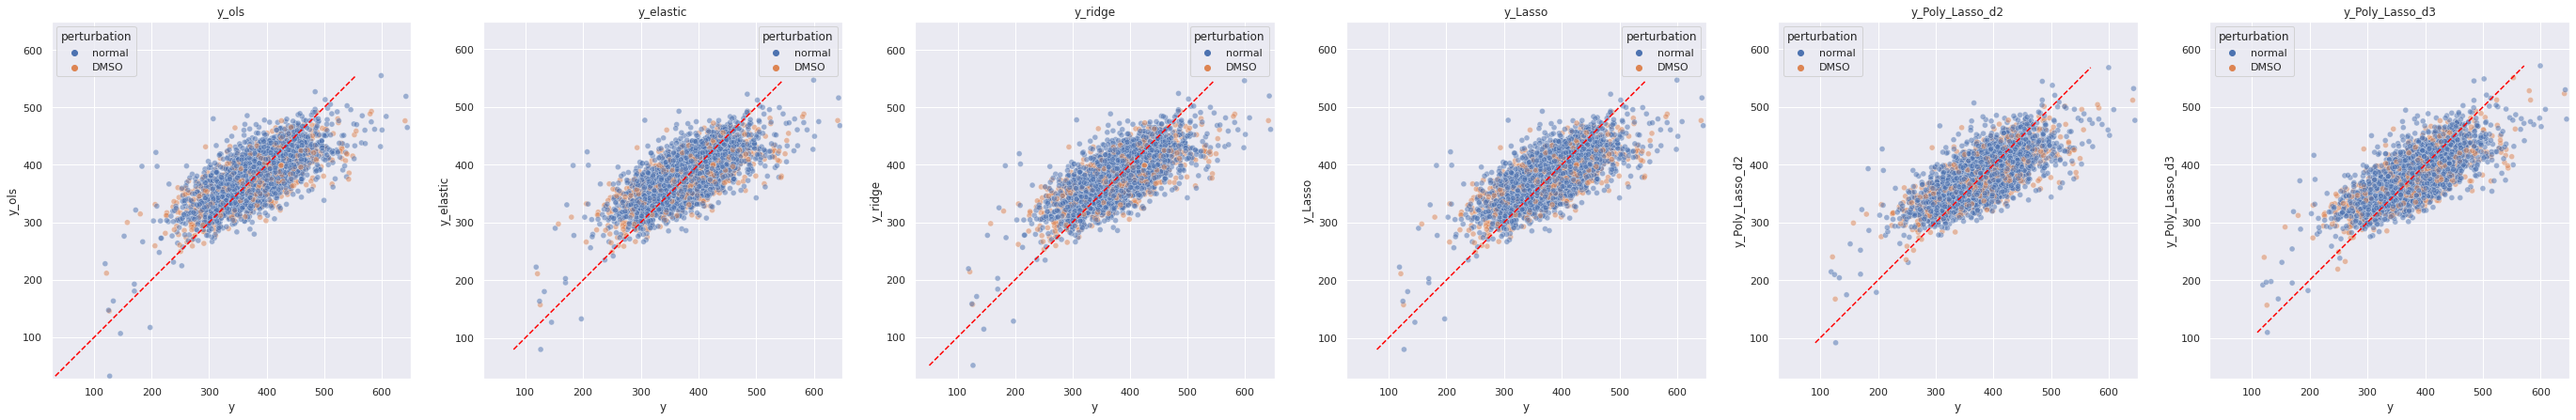

In [57]:
# Plot predictions
plt.figure(figsize=(len(y_models)*8,7))
for i, y_hat in enumerate(y_models, 1):
    plt.subplot(1, len(y_models), i)
    plot_y_vs_y_hat(df=predictions_df[mask_cv], y_hat=y_hat)
    plt.xlim([min_val, max_val])
    plt.ylim([min_val, max_val])

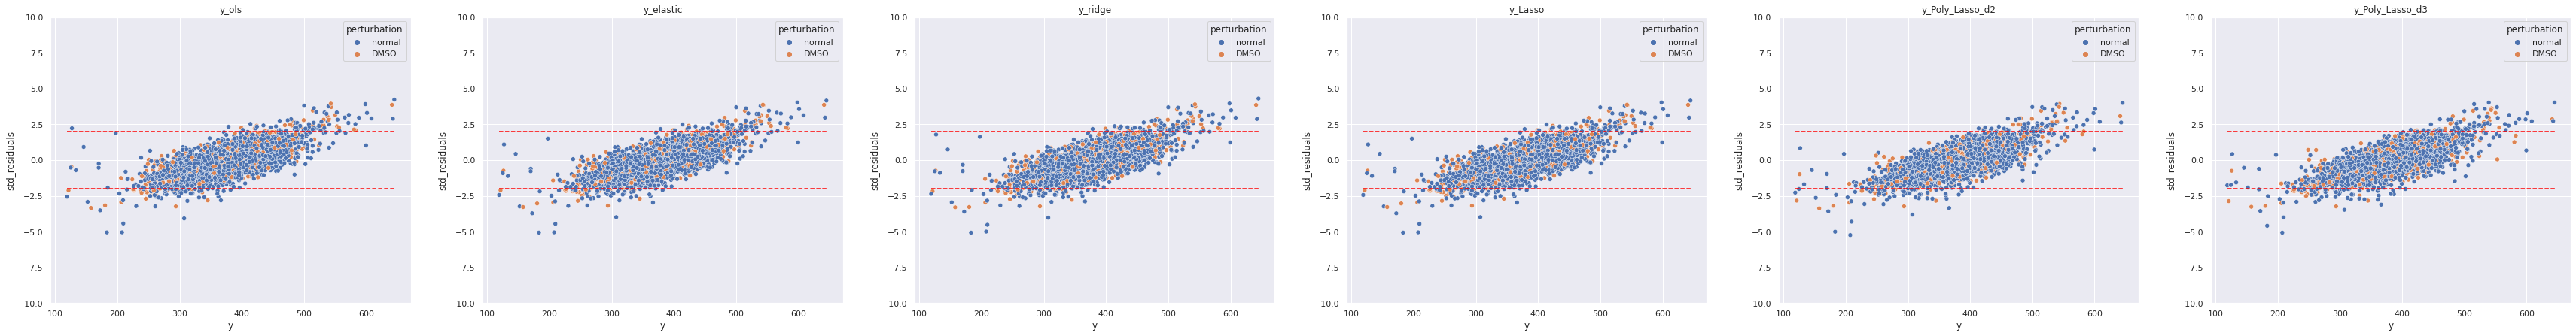

In [58]:
# Plot residuals
plt.figure(figsize=(len(y_models)*10,7))
for i, y_hat in enumerate(y_models, 1):
    plt.subplot(1, len(y_models), i)
    plot_residuals(df=predictions_df[mask_cv], y_hat=y_hat)
    #plt.xlim([min_val, max_val])
    plt.ylim([-10, 10])

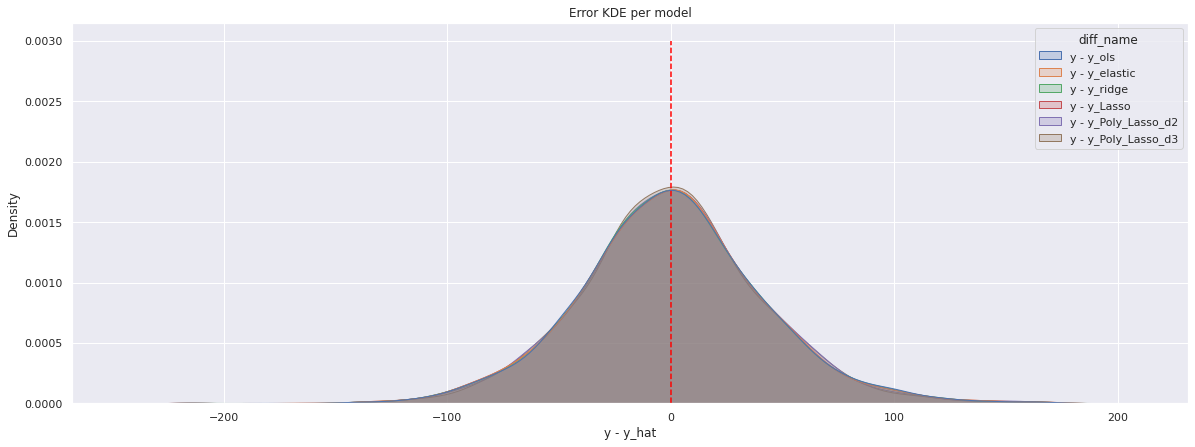

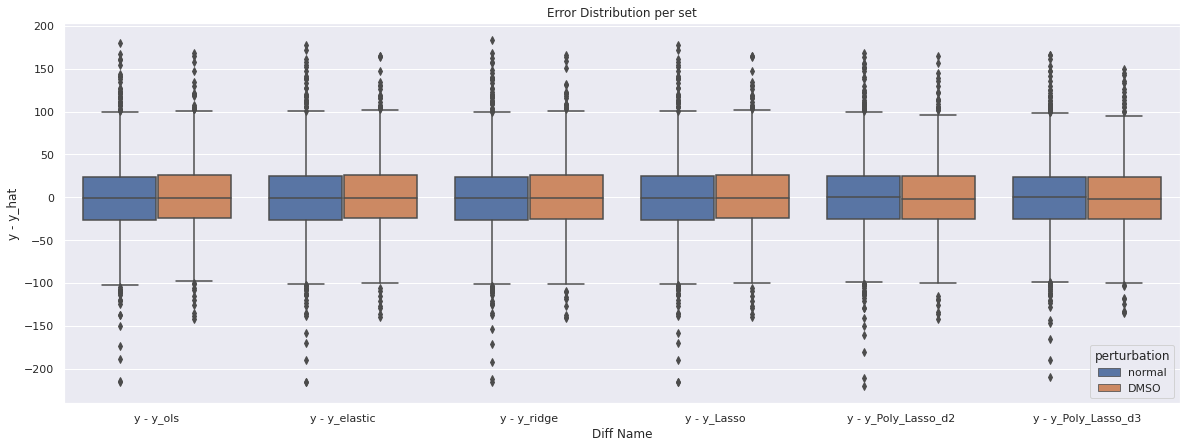

In [59]:
# Depper look into error distribution per model
plot_error_dist(predictions_df[mask_cv], y_models)

#TODO

#Add a heat map with the mse and the mae (maybe also r2)

In [60]:
# Save results so far
model_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Linear_models/Normal_DMSO_TSA'
    
with open(os.path.join(model_path, 'Predictions.csv'), 'w') as file:
    predictions_df.to_csv(file, index=False)
    
with open(os.path.join(model_path, 'Metric_vals.csv'), 'w') as file:
    metric_vals_df.to_csv(file, index=False)
    
with open(os.path.join(model_path, 'Coefficients.csv'), 'w') as file:
    coef_df.to_csv(file, index=False)
    
with open(os.path.join(model_path, 'Coefficients_poly_lasso_d2.csv'), 'w') as file:
    poly_lasso_coef_df_d2.to_csv(file, index=False)

with open(os.path.join(model_path, 'Coefficients_poly_lasso_d3.csv'), 'w') as file:
    poly_lasso_coef_df_d3.to_csv(file, index=False)

In [6]:
# Load results
model_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Linear_models/Normal_DMSO_TSA'

# Load files
with open(os.path.join(model_path, 'Predictions.csv'), 'r') as file:
    predictions_df = pd.read_csv(file)

with open(os.path.join(model_path, 'Metric_vals.csv'), 'r') as file:
    metric_vals_df = pd.read_csv(file)

with open(os.path.join(model_path, 'Coefficients.csv'), 'r') as file:
    coef_df = pd.read_csv(file)
    
with open(os.path.join(model_path, 'Coefficients_poly_lasso_d2.csv'), 'r') as file:
    poly_lasso_coef_df_d2 = pd.read_csv(file)

with open(os.path.join(model_path, 'Coefficients_poly_lasso_d3.csv'), 'r') as file:
    poly_lasso_coef_df_d2 = pd.read_csv(file)

In [7]:
#mask = (metric_vals_df['set'] == 'val')
#metric_vals_df[mask].sort_values(by=['R2'], ascending=False)
metric_vals_df

,model,set,R2,BIC,MSE,MAE,Huber
0,ols,train,0.5221,22469.5979,1811.3139,32.3570,31.8596
1,ols,val,0.4939,2951.0329,1760.3286,32.0866,31.5884
2,ols,test,0.4795,2974.1009,1593.4499,30.3740,29.8765
3,elastic,train,0.5190,22432.4751,1822.8744,32.3662,31.8698
4,elastic,val,0.5004,2904.8966,1737.6124,32.0889,31.5929
5,elastic,test,0.4810,2931.5352,1588.9699,30.3989,29.9021
6,ridge,train,0.5206,22478.8694,1816.9983,32.3354,31.8388
7,ridge,val,0.5040,2943.6352,1725.2946,32.0306,31.5332
8,ridge,test,0.4840,2970.8567,1579.7603,30.3191,29.8210
9,Lasso,train,0.5190,22432.4751,1822.8744,32.3662,31.8698


In [30]:
temp_df = coef_df.copy()
temp_df['positive'] = (temp_df['Ridge'] > 0)
temp_df['Ridge_abs'] = temp_df['Ridge'].abs()
temp_df = temp_df.sort_values(by=['Ridge_abs'], ascending=False)
temp_df = temp_df.reset_index()
temp_df = temp_df[['index', 'Ridge', 'positive']]
temp_df.columns = ['channel_id', 'Ridge_coef', 'positive']
temp_df

,channel_id,Ridge_coef,positive
0,0,203.5288,True
1,26,201.7258,True
2,9,117.0213,True
3,7,-95.3398,False
4,5,84.8067,True
5,23,-81.7129,False
6,15,-69.4017,False
7,19,60.0191,True
8,3,47.6009,True
9,28,-38.8788,False


In [31]:
with open(os.path.join('/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Without_Perturbations/baseline_CNN/131220_1017/',
                       'coefs_Ridge.csv'), 'w') as file:
    temp_df.to_csv(file, index=False)